In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist

In [2]:
pyro.set_rng_seed(545711891)

In [3]:
# Constants
testing = True # TODO: remove
n_train = 20
n_test = 10
N = n_train + n_test
beta = 100
X = torch.linspace(0.0, 1.0, N) # grid of observations
x_axis = torch.linspace(0.0, 1.0, 100) # used for graphing

In [4]:
# Function to learn
def g(x):
    return -(torch.sin(6*torch.pi*x))**2 + 6*x**2 - 5*x**4 + 3.0/2.0 

In [5]:
def sample_data(X, n_train, n_test):
    N = n_train + n_test
    # Partition sample points
    idx = np.random.permutation(N)
    X = X[idx]
    # Sample y_i = g(x_i) + ϵ
    noise = dist.Normal(0.0, beta**-1).sample(sample_shape=(N,))
    y = g(X) + noise
    return X[:n_train], y[:n_train], X[n_train:], y[n_train:]

In [6]:
def predict(model, X):
    with torch.no_grad():
        mean, cov = model(X, full_cov=True, noiseless=False)
    sd = cov.diag().sqrt()  # standard deviation at each input point x
    return mean, cov, sd

In [7]:
def plot_data(ax, X_train, y_train, X_test, y_test):
    ax.plot(X_train, y_train, 'kx', label='train')
    ax.plot(X_test, y_test, 'k.', label='test')
    ax.plot(x_axis, g(x_axis), 'r-', label='g(x)')
    ax.legend()

In [8]:
def plot_prior_samples(ax, model, n_samples=1):
    N = len(x_axis)
    noise = model.noise
    cov = model.kernel.forward(x_axis) + noise.expand(N).diag()
    samples = dist.MultivariateNormal(
        torch.zeros(N), covariance_matrix=cov
    ).sample(sample_shape=(n_samples,))
    ax.plot(x_axis, samples.T, lw=2)

In [9]:
def plot_predictions(ax, model, X_train, y_train, X_test, y_test):
    ax.plot(X_train, y_train, 'kx', label='train')
    ax.plot(X_test, y_test, 'k.', label='test')
    mean, cov, sd = predict(model, x_axis)
    ax.plot(x_axis, mean, "r", lw=2, label="GP prediction")  # plot the mean
    ax.fill_between(
        x_axis,  # plot the two-sigma uncertainty about the mean
        (mean - 2.0 * sd),
        (mean + 2.0 * sd),
        color="C0",
        alpha=0.3,
        label="GP uncertainty"
    )
    ax.legend()

In [10]:
def plot_loss(ax, loss):
    ax.plot(loss)
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Loss")

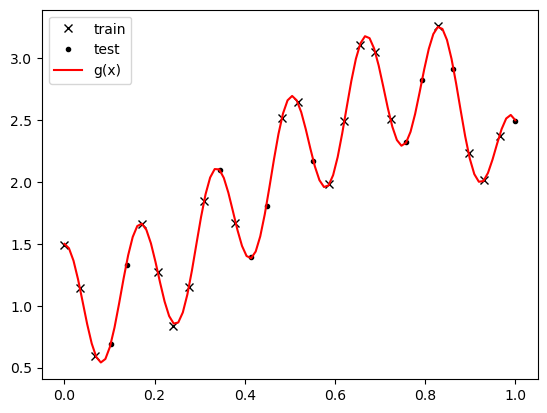

In [11]:
# Sample and plot the data
X_train, y_train, X_test, y_test = sample_data(X, n_train, n_test)
fig, ax = plt.subplots()
plot_data(ax, X_train, y_train, X_test, y_test)

In [12]:
# Define the model, choosing a periodic kernel
noise = torch.tensor(beta**-1)
kernel = gp.kernels.Periodic(input_dim=1)
gpr = gp.models.GPRegression(X_train, y_train, kernel, noise=noise)

# Create a regression model and choose som reasonable priors
gpr.kernel.variance    = pyro.sample("var", dist.Normal(1.0, 1.0))
gpr.kernel.lengthscale = pyro.sample("lengthscale", dist.Normal(1.0, 0.2))
gpr.kernel.period      = pyro.sample("period", dist.Normal(1.0, 0.2))

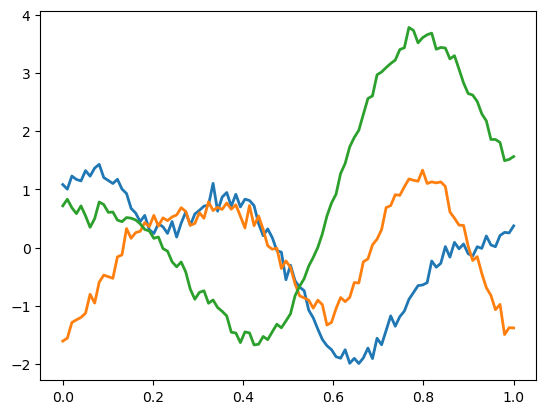

In [13]:
# Samples of unlearned GP
fig, ax = plt.subplots()
plot_prior_samples(ax, gpr, n_samples=3)

In [14]:
# We optimize the following parameters:
# variance, lengthscale, period
optimizer = torch.optim.Adam(gpr.parameters(), lr=0.01)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
num_steps = 2000 if not testing else 100
losses = gp.util.train(
    gpr,
    optimizer=optimizer, loss_fn=loss_fn,
    num_steps=num_steps
)

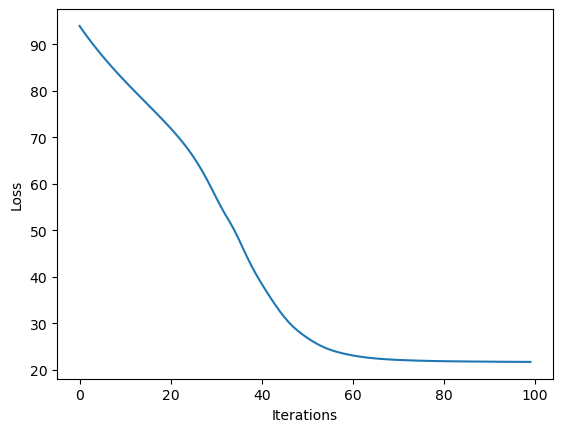

In [15]:
# Plot losses
fig, ax = plt.subplots()
plot_loss(ax, losses)

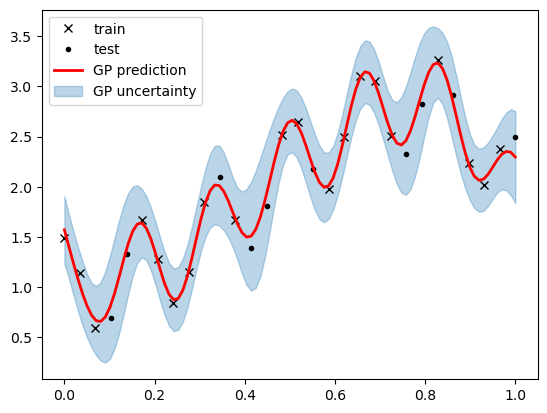

In [16]:
fig, ax = plt.subplots()
plot_predictions(
    ax=ax, model=gpr,
    X_train=X_train, y_train=y_train,
    X_test=X_test, y_test=y_test
)

In [17]:
print(f"variance:    {gpr.kernel.variance.item()}")
print(f"lengthscale: {gpr.kernel.lengthscale.item()}")
print(f"period:      {gpr.kernel.period.item()}")
print(f"noise:       {gpr.noise.item()}")

variance:    4.771026134490967
lengthscale: 0.48270148038864136
period:      1.0538909435272217
noise:       0.01531507819890976


In [18]:
# Calculate the log-likelihood of the predictions
mean_pred, cov_pred, _ = predict(gpr, X_test)
log_likelihood = dist.MultivariateNormal(
    mean_pred,
    cov_pred
).log_prob(y_test)
print(f"Log-likelihood of test samples: {log_likelihood}")

Log-likelihood of test samples: 5.402746200561523
